# Vanilla RNN Implementation  

RNN을 이용한 sequence modeling을 실습하기 전에, 가장 기초적인 형태의 RNN 레이어를 실제로 구현해 보겠습니다.  
향후 실습과정의 대부분은 keras를 기반으로 진행됩니다.  
따라서 이번 장의 RNN 레이어 구현 과정을 통해 keras의 기본개념을 익히는 과정도 함께 진행해 보겠습니다.

(참고)  
https://keras.io/layers/recurrent/   
케라스 창시자에게 배우는 딥러닝(프랑소와 숄레 저/박해선 역) 3.2.2절

### keras 기본 워크플로우  

지난 절에서 우리는 Multi-layer Perceptron을 활용한 sequence modeling을 구현하면서 이미 keras를 활용한 바 있습니다.  
대략 다음과 같은 구조를 가지고 있었습니다.

```
from keras.models import Sequential
from keras.layers import Dense

# step 1. define Dataset
df = pd.read_csv(dataset_filepath)
train_data = [([df.iat[i+j,1] for j in range(5)], df.iat[i+5,1]) for i in range(115)]
test_data = [([df.iat[i+j,1] for j in range(5)], df.iat[i+5,1]) for i in range(115, 139)]

# step 2. define Model with Layers
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=5))
model.add(Dense(1))

# step 3. define how to train with loss/optimizer
model.compile(optimizer='adam', loss='mse')

# step 4. fit model to train
model.fit(X_train, y_train, epochs=1000, verbose=1, validation_data=(X_val, y_val))

# step 5. inference
cur_y_hat = model.predict(x_input_reshape, verbose=0)
```

위 소스코드는 keras의 창시자인 프랑소아 숄레의 저서에서 소개된 keras의 기본 워크플로우를 잘 보여 줍니다.  

step 1 : [dataset]       입력 텐서와 타깃 텐서로 이루어진 훈련데이터를 정의한다.  
step 2 : [model, layer]  입력과 타깃을 매핑하는 층(layer)으로 이루어진 네트워크(model)을 정의한다.  
step 3 : [model.compile] 손실 함수, 옵티마이저, 모니터링하기 위한 측정 지표를 선택하여 학습 과정을 설정한다.  
step 4 : [model.fit]     훈련 데이터에 대해 모델의 fit() 메소드를 반복적으로 호출한다.  
step 5 : [model.predict] 훈련이 끝난 model을 활용하여 테스트데이터를 해석한다.

MLP 대신 RNN을 활용하기 위한 작업은 위 step 2에 해당하는 작업입니다.  
그러나 모델 구조가 바뀌면 step 1의 데이터구조, step 3의 측정 지표 등이 함께 영향을 받게 되므로 종합적인 검토가 필요합니다.

### sequential model  

keras가 tensorflow, pytorch 등 딥러닝 프레임워크들에 비해 High Level 프레임워크라고 평가받게 되는 가장 중요한 특징이 keras의 model에 있습니다.  
keras.model 클래스 안에는 keras 워크플로우를 구성하는 compile, fit, predict 등 주요한 메소드들이 모두 포함되어 있습니다. 즉 keras.model은 keras의 가장 핵심 클래스라고 할 수 있습니다.   (참고) https://keras.io/models/model/  
이 클래스를 통해 keras는 딥러닝 워크플로우를 표준화하여 내부에 미리 구현함으로써, 사용자들로 하여금 최소한의 코딩만으로 손쉽게 딥러닝 모델을 구현하여 운영할 수 있게 됩니다.  

특히 가장 많이 활용되는 대표적인 model인 sequence model은 이전 layer의 출력이 다음 layer의 입력이 되게끔 layer들이 sequence 구조로 배치된 아키텍처를 구현하였습니다. 이번 실습에서는 sequence model 내부의 Dense layer를 간단한 RNN 레이어로 바꾸어 보는 작업을 진행해 보겠습니다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, RNN
from keras import backend as K

Using TensorFlow backend.


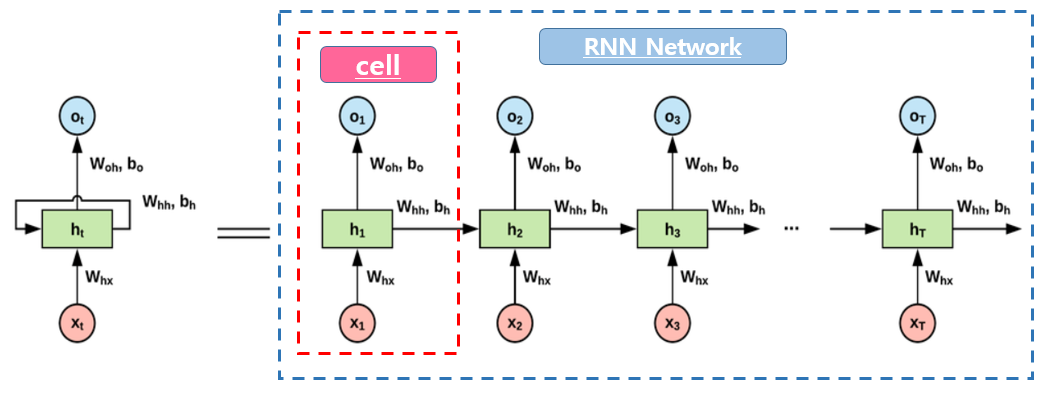

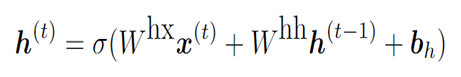

In [2]:
# from https://keras.io/layers/recurrent/

class MinimalRNNCell(keras.layers.Layer):

    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = units
        super(MinimalRNNCell, self).__init__(**kwargs)

    def build(self, input_shape):
        # Whx 
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer='uniform',
                                      name='kernel')
        # Whh
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units),
            initializer='uniform',
            name='recurrent_kernel')
        # bh
        self.bias = self.add_weight(
            shape=(1, self.units),
            initializer='uniform',
            name='bias')
        self.built = True

    def call(self, inputs, states):
        prev_output = states[0]
        h = K.dot(inputs, self.kernel)
        output = h + K.dot(prev_output, self.recurrent_kernel) + self.bias
#         output = keras.activations.sigmoid(output)
        return output, [output]


keras의 layer는 반드시 build와 call 메소드를 구현해야 합니다.  
build 메소드 안에서 layer는 add_weight 메소드를 활용하여 이 layer의 파라미터 구성을 정의합니다.  
call 메소드는 해당 layer의 실제 로직을 구현합니다. layer의 입력과 출력, build에서 정의한 파라미터들 사이에 어떤 연산을 거치게 되는지를 정의합니다. 

In [3]:
x = keras.Input((None, 5))
print(x)

Tensor("input_1:0", shape=(?, ?, 5), dtype=float32)


In [4]:
cell = MinimalRNNCell(32)
layer = RNN(cell)
h = layer(x)
print(h)

Instructions for updating:
Colocations handled automatically by placer.
Tensor("rnn_1/TensorArrayReadV3:0", shape=(?, 32), dtype=float32)


MinimalRNNCell을 사용한 가장 간단한 vanilla RNN을 구현해 보았습니다.  
이 RNN layer를 활용하여 이전 장과 동일한 time series forcasting을 수행해 보겠습니다.

In [5]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [6]:
# csv 포맷의 데이터 경로를 지정합니다.
dataset_filepath = 'datasets/airline-passengers.csv'
# csv 파일을 읽어들여 DataFrame 객체를 생성합니다.
df = pd.read_csv(dataset_filepath)

In [7]:
train_data = [([df.iat[i+j,1] for j in range(5)], df.iat[i+5,1]) for i in range(115)]
test_data = [([df.iat[i+j,1] for j in range(5)], df.iat[i+5,1]) for i in range(115, 139)]
X_train = np.array([X for (X,y) in train_data])
X_test = np.array([X for (X,y) in test_data])
y_train = np.array([y for (X,y) in train_data])
y_test = np.array([y for (X,y) in test_data])
X_val = X_test
y_val = y_test

In [8]:
# RNN의 경우 Dense와 입출력 tensor shape가 다르다.
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [9]:
# to reproduce same training result
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [20]:
cell = MinimalRNNCell(50)
# cell.build((5, 1))
rnn_layer = RNN(cell)
# rnn_layer.build((5, 1))

# define model
model = Sequential()
#model.add(Dense(100, activation='relu', input_dim=5))   
model.add(rnn_layer)  # Dense Layer 대신 RNN Layer를 사용
model.add(Dense(1))
model.build((None, 5, 1))   # model의 input shape를 지정해 주어야 summary가 가능하다.
model.summary()

model.compile(optimizer='adam', loss='mse')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_12 (RNN)                 (None, 50)                2600      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 51        
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [23]:
# fit model
model.fit(X_train, y_train, epochs=1000, verbose=1, validation_data=(X_val, y_val))

Train on 115 samples, validate on 24 samples
Epoch 1/1000
115/115 [==============================] - 1s 5ms/step - loss: 68592.5199 - val_loss: 180959.7500
Epoch 2/1000
115/115 [==============================] - 0s 321us/step - loss: 58132.4001 - val_loss: 152895.4375
Epoch 3/1000
115/115 [==============================] - 0s 321us/step - loss: 48698.7080 - val_loss: 121581.4375
Epoch 4/1000
115/115 [==============================] - 0s 312us/step - loss: 37261.9125 - val_loss: 84556.1172
Epoch 5/1000
115/115 [==============================] - 0s 304us/step - loss: 23934.1561 - val_loss: 40845.9336
Epoch 6/1000
115/115 [==============================] - 0s 326us/step - loss: 8777.3802 - val_loss: 7364.8203
Epoch 7/1000
115/115 [==============================] - 0s 286us/step - loss: 3539.4134 - val_loss: 22303.2500
Epoch 8/1000
115/115 [==============================] - 0s 278us/step - loss: 6921.8547 - val_loss: 12179.7998
Epoch 9/1000
115/115 [==============================] - 0s 270

115/115 [==============================] - 0s 251us/step - loss: 1076.8282 - val_loss: 3478.0969
Epoch 148/1000
115/115 [==============================] - 0s 234us/step - loss: 1068.4695 - val_loss: 3447.0762
Epoch 149/1000
115/115 [==============================] - 0s 234us/step - loss: 1095.8298 - val_loss: 3423.0989
Epoch 150/1000
115/115 [==============================] - 0s 251us/step - loss: 1049.9824 - val_loss: 3549.4172
Epoch 151/1000
115/115 [==============================] - 0s 225us/step - loss: 1077.6367 - val_loss: 3383.0508
Epoch 152/1000
115/115 [==============================] - 0s 225us/step - loss: 1035.5247 - val_loss: 3354.5300
Epoch 153/1000
115/115 [==============================] - 0s 217us/step - loss: 1081.6348 - val_loss: 3433.6902
Epoch 154/1000
115/115 [==============================] - 0s 234us/step - loss: 1023.7942 - val_loss: 3385.6345
Epoch 155/1000
115/115 [==============================] - 0s 217us/step - loss: 1080.1172 - val_loss: 3461.0938
Epoch 1

Epoch 221/1000
115/115 [==============================] - 0s 243us/step - loss: 846.9499 - val_loss: 2693.2910
Epoch 222/1000
115/115 [==============================] - 0s 243us/step - loss: 840.2560 - val_loss: 2662.1997
Epoch 223/1000
115/115 [==============================] - 0s 225us/step - loss: 840.0604 - val_loss: 2729.8152
Epoch 224/1000
115/115 [==============================] - 0s 225us/step - loss: 848.3500 - val_loss: 2665.5110
Epoch 225/1000
115/115 [==============================] - 0s 225us/step - loss: 825.3600 - val_loss: 2653.7107
Epoch 226/1000
115/115 [==============================] - 0s 225us/step - loss: 833.0031 - val_loss: 2657.5916
Epoch 227/1000
115/115 [==============================] - 0s 234us/step - loss: 834.3919 - val_loss: 2639.5645
Epoch 228/1000
115/115 [==============================] - 0s 269us/step - loss: 842.0837 - val_loss: 2663.4363
Epoch 229/1000
115/115 [==============================] - 0s 304us/step - loss: 843.6108 - val_loss: 2630.8521
E

Epoch 295/1000
115/115 [==============================] - 0s 236us/step - loss: 763.9308 - val_loss: 2378.9407
Epoch 296/1000
115/115 [==============================] - 0s 234us/step - loss: 766.0498 - val_loss: 2374.6672
Epoch 297/1000
115/115 [==============================] - 0s 234us/step - loss: 761.7018 - val_loss: 2383.8560
Epoch 298/1000
115/115 [==============================] - 0s 243us/step - loss: 763.4985 - val_loss: 2368.5315
Epoch 299/1000
115/115 [==============================] - 0s 243us/step - loss: 756.6524 - val_loss: 2367.7695
Epoch 300/1000
115/115 [==============================] - 0s 234us/step - loss: 755.9994 - val_loss: 2366.2800
Epoch 301/1000
115/115 [==============================] - 0s 251us/step - loss: 756.0092 - val_loss: 2366.2278
Epoch 302/1000
115/115 [==============================] - 0s 256us/step - loss: 774.4814 - val_loss: 2356.4043
Epoch 303/1000
115/115 [==============================] - 0s 243us/step - loss: 756.3517 - val_loss: 2364.9402
E

Epoch 369/1000
115/115 [==============================] - 0s 243us/step - loss: 713.8035 - val_loss: 2232.7039
Epoch 370/1000
115/115 [==============================] - 0s 234us/step - loss: 728.4074 - val_loss: 2227.6123
Epoch 371/1000
115/115 [==============================] - 0s 225us/step - loss: 719.1557 - val_loss: 2249.4717
Epoch 372/1000
115/115 [==============================] - 0s 225us/step - loss: 732.0840 - val_loss: 2212.5098
Epoch 373/1000
115/115 [==============================] - 0s 251us/step - loss: 712.3106 - val_loss: 2222.6528
Epoch 374/1000
115/115 [==============================] - 0s 251us/step - loss: 724.9928 - val_loss: 2206.1736
Epoch 375/1000
115/115 [==============================] - 0s 217us/step - loss: 708.2915 - val_loss: 2220.6116
Epoch 376/1000
115/115 [==============================] - 0s 234us/step - loss: 718.7105 - val_loss: 2226.8328
Epoch 377/1000
115/115 [==============================] - 0s 225us/step - loss: 705.3670 - val_loss: 2203.9949
E

Epoch 443/1000
115/115 [==============================] - 0s 234us/step - loss: 671.7245 - val_loss: 2182.8425
Epoch 444/1000
115/115 [==============================] - 0s 234us/step - loss: 675.0024 - val_loss: 2132.2610
Epoch 445/1000
115/115 [==============================] - 0s 243us/step - loss: 671.3202 - val_loss: 2134.7874
Epoch 446/1000
115/115 [==============================] - 0s 234us/step - loss: 665.9913 - val_loss: 2140.4583
Epoch 447/1000
115/115 [==============================] - 0s 225us/step - loss: 662.8364 - val_loss: 2138.6143
Epoch 448/1000
115/115 [==============================] - 0s 225us/step - loss: 674.0794 - val_loss: 2132.5234
Epoch 449/1000
115/115 [==============================] - 0s 234us/step - loss: 665.7353 - val_loss: 2173.3665
Epoch 450/1000
115/115 [==============================] - 0s 225us/step - loss: 702.2735 - val_loss: 2133.5300
Epoch 451/1000
115/115 [==============================] - 0s 234us/step - loss: 656.4582 - val_loss: 2197.6565
E

Epoch 517/1000
115/115 [==============================] - 0s 252us/step - loss: 663.1392 - val_loss: 2135.3726
Epoch 518/1000
115/115 [==============================] - 0s 225us/step - loss: 668.1759 - val_loss: 2134.3401
Epoch 519/1000
115/115 [==============================] - 0s 234us/step - loss: 660.5336 - val_loss: 2115.6306
Epoch 520/1000
115/115 [==============================] - 0s 225us/step - loss: 667.0921 - val_loss: 2119.4380
Epoch 521/1000
115/115 [==============================] - 0s 234us/step - loss: 664.7607 - val_loss: 2124.3159
Epoch 522/1000
115/115 [==============================] - 0s 234us/step - loss: 662.5089 - val_loss: 2131.3262
Epoch 523/1000
115/115 [==============================] - 0s 243us/step - loss: 669.8232 - val_loss: 2117.0071
Epoch 524/1000
115/115 [==============================] - 0s 243us/step - loss: 673.0061 - val_loss: 2114.1487
Epoch 525/1000
115/115 [==============================] - 0s 251us/step - loss: 670.6371 - val_loss: 2158.9841
E

Epoch 591/1000
115/115 [==============================] - 0s 243us/step - loss: 660.9848 - val_loss: 2124.9976
Epoch 592/1000
115/115 [==============================] - 0s 234us/step - loss: 663.7500 - val_loss: 2128.6428
Epoch 593/1000
115/115 [==============================] - 0s 251us/step - loss: 668.9858 - val_loss: 2119.1875
Epoch 594/1000
115/115 [==============================] - 0s 225us/step - loss: 670.9716 - val_loss: 2151.6897
Epoch 595/1000
115/115 [==============================] - 0s 234us/step - loss: 661.4289 - val_loss: 2111.9463
Epoch 596/1000
115/115 [==============================] - 0s 243us/step - loss: 668.5651 - val_loss: 2111.7009
Epoch 597/1000
115/115 [==============================] - 0s 225us/step - loss: 663.1073 - val_loss: 2120.1150
Epoch 598/1000
115/115 [==============================] - 0s 243us/step - loss: 675.3999 - val_loss: 2120.1130
Epoch 599/1000
115/115 [==============================] - 0s 225us/step - loss: 662.0295 - val_loss: 2120.3367
E

Epoch 665/1000
115/115 [==============================] - 0s 234us/step - loss: 667.6014 - val_loss: 2113.2151
Epoch 666/1000
115/115 [==============================] - 0s 226us/step - loss: 675.6317 - val_loss: 2207.2104
Epoch 667/1000
115/115 [==============================] - 0s 225us/step - loss: 671.3931 - val_loss: 2107.7957
Epoch 668/1000
115/115 [==============================] - 0s 225us/step - loss: 674.5012 - val_loss: 2144.2625
Epoch 669/1000
115/115 [==============================] - 0s 234us/step - loss: 668.4300 - val_loss: 2111.6240
Epoch 670/1000
115/115 [==============================] - 0s 225us/step - loss: 673.1155 - val_loss: 2207.1172
Epoch 671/1000
115/115 [==============================] - 0s 251us/step - loss: 672.5758 - val_loss: 2105.2410
Epoch 672/1000
115/115 [==============================] - 0s 234us/step - loss: 659.3675 - val_loss: 2128.6687
Epoch 673/1000
115/115 [==============================] - 0s 234us/step - loss: 676.8693 - val_loss: 2104.2922
E

Epoch 739/1000
115/115 [==============================] - 0s 260us/step - loss: 674.6660 - val_loss: 2105.1506
Epoch 740/1000
115/115 [==============================] - 0s 234us/step - loss: 662.5278 - val_loss: 2122.3247
Epoch 741/1000
115/115 [==============================] - 0s 225us/step - loss: 661.6521 - val_loss: 2114.7307
Epoch 742/1000
115/115 [==============================] - 0s 243us/step - loss: 658.1359 - val_loss: 2103.9363
Epoch 743/1000
115/115 [==============================] - 0s 234us/step - loss: 657.8951 - val_loss: 2106.0337
Epoch 744/1000
115/115 [==============================] - 0s 225us/step - loss: 663.2917 - val_loss: 2108.3391
Epoch 745/1000
115/115 [==============================] - 0s 234us/step - loss: 659.4325 - val_loss: 2109.0037
Epoch 746/1000
115/115 [==============================] - 0s 234us/step - loss: 673.5925 - val_loss: 2122.7070
Epoch 747/1000
115/115 [==============================] - 0s 234us/step - loss: 656.9659 - val_loss: 2107.8245
E

Epoch 813/1000
115/115 [==============================] - 0s 234us/step - loss: 666.1485 - val_loss: 2112.7886
Epoch 814/1000
115/115 [==============================] - 0s 243us/step - loss: 676.7887 - val_loss: 2167.0647
Epoch 815/1000
115/115 [==============================] - 0s 217us/step - loss: 661.2802 - val_loss: 2106.7627
Epoch 816/1000
115/115 [==============================] - 0s 234us/step - loss: 677.0306 - val_loss: 2113.3440
Epoch 817/1000
115/115 [==============================] - 0s 225us/step - loss: 664.0124 - val_loss: 2128.4951
Epoch 818/1000
115/115 [==============================] - 0s 217us/step - loss: 672.9311 - val_loss: 2155.7185
Epoch 819/1000
115/115 [==============================] - 0s 252us/step - loss: 666.3948 - val_loss: 2098.9612
Epoch 820/1000
115/115 [==============================] - 0s 243us/step - loss: 662.4648 - val_loss: 2097.0417
Epoch 821/1000
115/115 [==============================] - 0s 234us/step - loss: 661.5751 - val_loss: 2122.8945
E

Epoch 960/1000
115/115 [==============================] - 0s 243us/step - loss: 666.0048 - val_loss: 2108.2092
Epoch 961/1000
115/115 [==============================] - 0s 234us/step - loss: 657.9240 - val_loss: 2108.5605
Epoch 962/1000
115/115 [==============================] - 0s 225us/step - loss: 659.2235 - val_loss: 2106.2322
Epoch 963/1000
115/115 [==============================] - 0s 217us/step - loss: 674.3193 - val_loss: 2114.6677
Epoch 964/1000
115/115 [==============================] - 0s 226us/step - loss: 661.6887 - val_loss: 2211.2043
Epoch 965/1000
115/115 [==============================] - 0s 225us/step - loss: 675.0400 - val_loss: 2138.5879
Epoch 966/1000
115/115 [==============================] - 0s 234us/step - loss: 658.5402 - val_loss: 2107.6650
Epoch 967/1000
115/115 [==============================] - 0s 225us/step - loss: 661.2069 - val_loss: 2107.2734
Epoch 968/1000
115/115 [==============================] - 0s 225us/step - loss: 663.6721 - val_loss: 2106.0479
E

In [24]:
# check how exactly fit train data

y_hats = []
cur_y_hat = 0
for i in range(115):
    x_input = X_train[i]
    x_input_reshape = x_input.reshape(1,5,1)
    cur_y_hat = model.predict(x_input_reshape, verbose=0)
    cur_y_hat = np.squeeze(cur_y_hat)
    print('TRAIN DATA %d : predicted=%f, ground_truth=%d' % (i, cur_y_hat, y_train[i]))
    y_hats.append(cur_y_hat)

TRAIN DATA 0 : predicted=120.191406, ground_truth=135
TRAIN DATA 1 : predicted=140.191986, ground_truth=148
TRAIN DATA 2 : predicted=153.536377, ground_truth=148
TRAIN DATA 3 : predicted=150.091507, ground_truth=136
TRAIN DATA 4 : predicted=130.835434, ground_truth=119
TRAIN DATA 5 : predicted=116.443466, ground_truth=104
TRAIN DATA 6 : predicted=108.155396, ground_truth=118
TRAIN DATA 7 : predicted=134.021271, ground_truth=115
TRAIN DATA 8 : predicted=121.048599, ground_truth=126
TRAIN DATA 9 : predicted=137.187851, ground_truth=141
TRAIN DATA 10 : predicted=142.139648, ground_truth=135
TRAIN DATA 11 : predicted=133.639771, ground_truth=125
TRAIN DATA 12 : predicted=122.634842, ground_truth=149
TRAIN DATA 13 : predicted=157.312012, ground_truth=170
TRAIN DATA 14 : predicted=176.507477, ground_truth=170
TRAIN DATA 15 : predicted=170.082062, ground_truth=158
TRAIN DATA 16 : predicted=149.005722, ground_truth=133
TRAIN DATA 17 : predicted=125.560593, ground_truth=114
TRAIN DATA 18 : pred

Text(0.5, 1.0, 'RMSE: 25.6209')

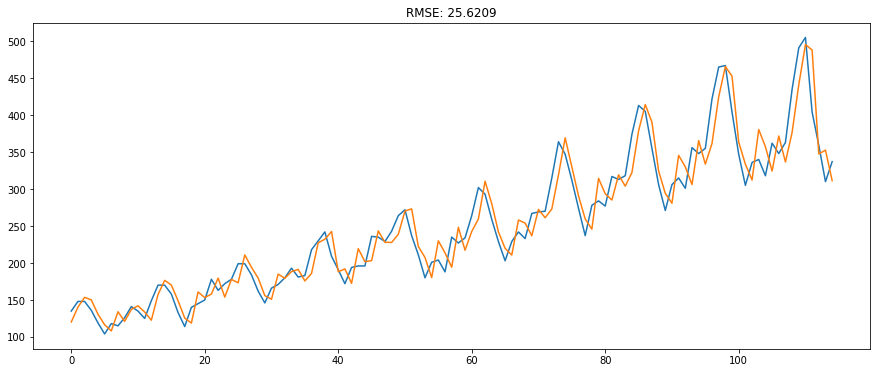

In [25]:
plt.plot(y_train)
plt.plot(y_hats)
plt.title('RMSE: %.4f'% np.sqrt(sum((y_hats-y_train)**2)/len(y_train)))

In [26]:
# predict with trained model

y_hats = []
cur_y_hat = 0
for i in range(24):
    if i == 0:  # test data 의 맨 첫번째 row에 대해서만 X 값을 그대로 활용
        x_input = X_test[0]
    else:       # 두번째 row부터는 이전 row의 prediction을 반영하여 X를 재구성
        x_input = x_input.tolist()
        del x_input[0]
        x_input.append(cur_y_hat)
        x_input = np.array(x_input)
    x_input_reshape = x_input.reshape(1,5,1)
    cur_y_hat = model.predict(x_input_reshape, verbose=0)
    cur_y_hat = np.squeeze(cur_y_hat)
    print('TEST DATA %d : predicted=%f, ground_truth=%d' % (i, cur_y_hat, y_test[i]))
    y_hats.append(cur_y_hat)

TEST DATA 0 : predicted=393.034576, ground_truth=360
TEST DATA 1 : predicted=422.501343, ground_truth=342
TEST DATA 2 : predicted=433.603912, ground_truth=406
TEST DATA 3 : predicted=419.511322, ground_truth=396
TEST DATA 4 : predicted=395.186554, ground_truth=420
TEST DATA 5 : predicted=383.413300, ground_truth=472
TEST DATA 6 : predicted=385.134094, ground_truth=548
TEST DATA 7 : predicted=396.485321, ground_truth=559
TEST DATA 8 : predicted=409.807343, ground_truth=463
TEST DATA 9 : predicted=416.550446, ground_truth=407
TEST DATA 10 : predicted=416.018311, ground_truth=362
TEST DATA 11 : predicted=411.737640, ground_truth=405
TEST DATA 12 : predicted=407.896912, ground_truth=417
TEST DATA 13 : predicted=407.626373, ground_truth=391
TEST DATA 14 : predicted=410.824188, ground_truth=419
TEST DATA 15 : predicted=415.332642, ground_truth=461
TEST DATA 16 : predicted=419.016876, ground_truth=472
TEST DATA 17 : predicted=420.783997, ground_truth=535
TEST DATA 18 : predicted=420.998627, g

Text(0.5, 1.0, 'RMSE: 86.4652')

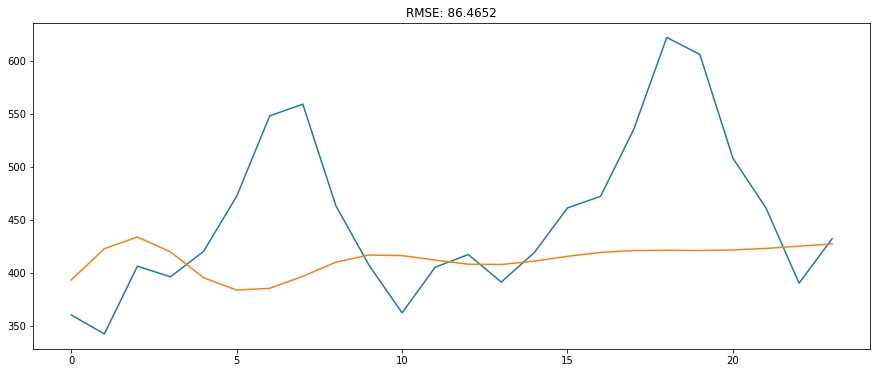

In [27]:
plt.plot(y_test)
plt.plot(y_hats)
plt.title('RMSE: %.4f'% np.sqrt(sum((y_hats-y_test)**2)/len(y_test)))